In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:48: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:48: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:51: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


# Amihud (2002) Annual portfolio sorts

In [5]:
sector_zscores=sector_XS_normalized(amihud)

In [6]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')
sector_rtns['All']=np.log(cleansed.resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """


In [7]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,3)

tsmom_model.py:240: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
tsmom_model.py:241: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


In [8]:
factors=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors[s]=sector_portfolio_sorts[s]['2']-sector_portfolio_sorts[s]['0']


In [9]:
factors.mean()

Agriculturals    0.001956
All              0.002641
Currencies       0.004412
Energies         0.006516
Equities         0.004662
Metals          -0.000710
Fixed Income     0.001267
dtype: float64

In [13]:
final_res=pd.DataFrame()
betas_res=pd.DataFrame()
alpha={}
tstat={}
for sec in factors.columns:
    ind=factors.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    #reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')
    res=sm.OLS(factors[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['AA']=res.params *100
        betas_res['AA_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha1']=pd.Series(alpha)*100
final_res['tstat']=pd.Series(tstat)

# FHT Annual portfolio sorts

In [14]:
FHT=calculate_FHT(cleansed)
sector_zscores=sector_XS_normalized(FHT)

tsmom_model.py:306: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:307: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:308: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:308: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [15]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,3)
sector_portfolio_sorts['All']=quantile_portfolios_annual(FHT,cleansed,3)

In [16]:
factors_FHT=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors_FHT[s]=sector_portfolio_sorts[s]['2']-sector_portfolio_sorts[s]['0']


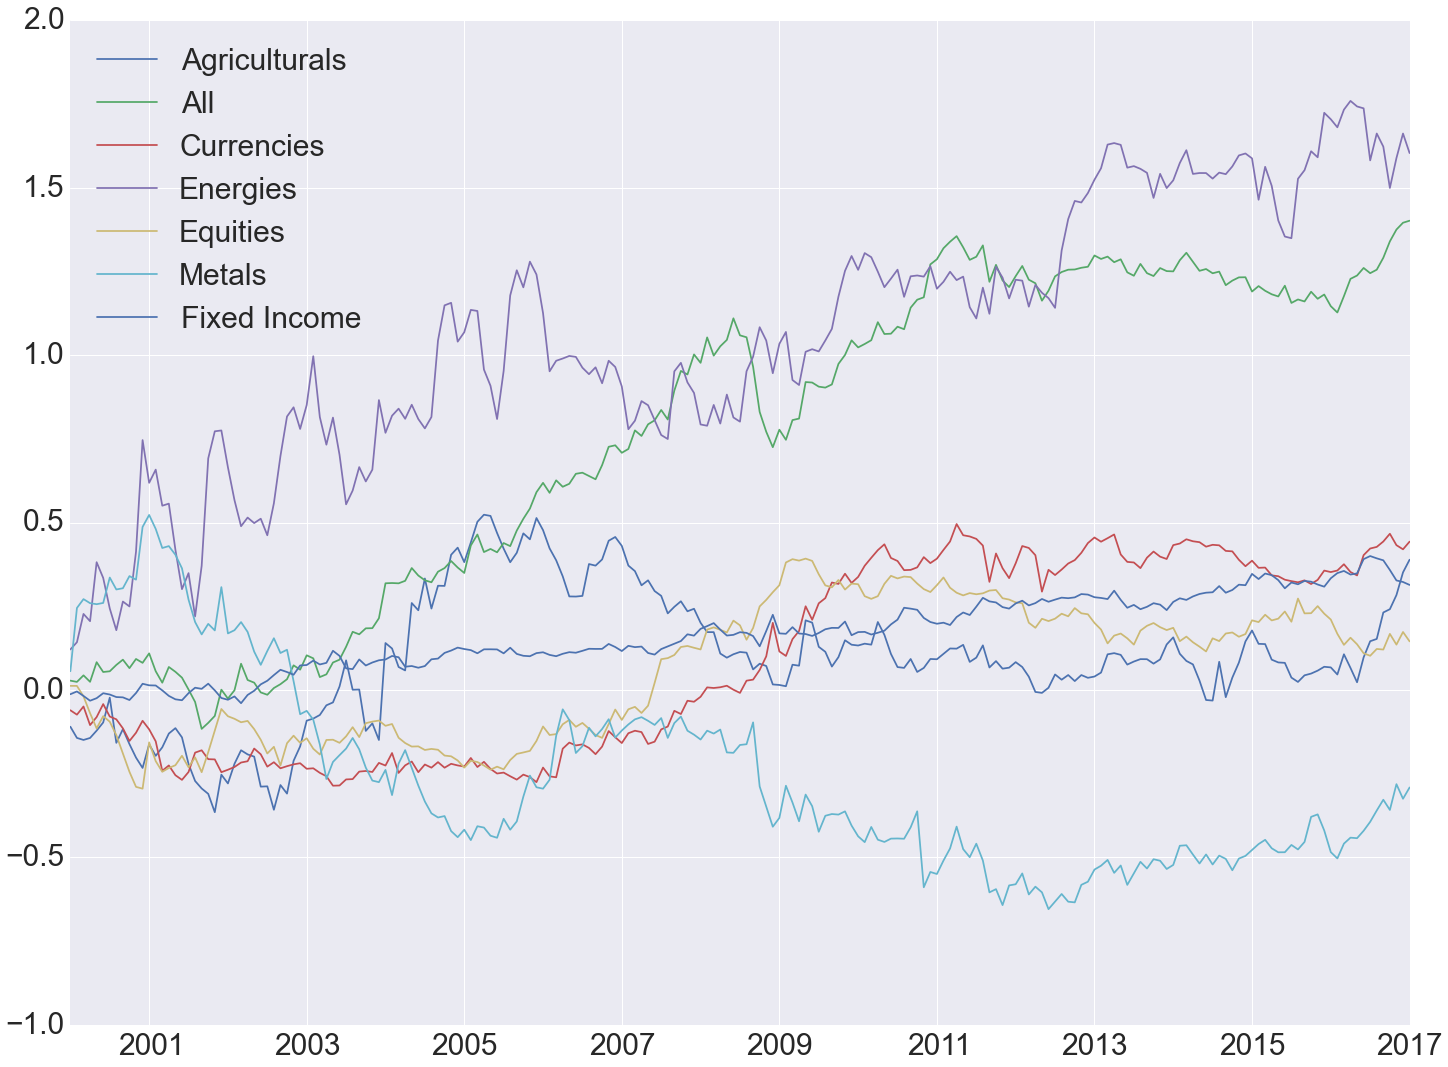

In [17]:
factors_FHT['2000':].cumsum().plot()

In [18]:
alpha={}
tstat={}
for sec in factors_FHT.columns:
    ind=factors_FHT['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    #reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')
    res=sm.OLS(factors_FHT[sec]['2000':'2016'],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['FA']=res.params  *100
        betas_res['FA_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha F-A']=pd.Series(alpha)*100
final_res['tstat2']=pd.Series(tstat)

In [19]:
final_res

,alpha1,tstat,alpha F-A,tstat2
Agriculturals,0.292706,0.923185,0.234909,0.671411
All,0.505644,2.945640,0.618088,3.950819
Currencies,0.216395,1.387951,0.216793,1.146649
Energies,0.309175,0.375868,0.857008,1.298343
Equities,0.703638,3.461960,0.157116,0.693154
Fixed Income,0.043947,1.024600,-0.033734,-1.046072
Metals,-0.217278,-0.599442,-0.122875,-0.388558


# Monthly portoflio sorts

In [20]:
amihud_monthly = read_monthly(amihud=True,sorts=3,xs=True)

In [21]:
factors_monthly=pd.DataFrame()
for s in amihud_monthly.keys():
    factors_monthly[s]=amihud_monthly[s]['2']-amihud_monthly[s]['0']


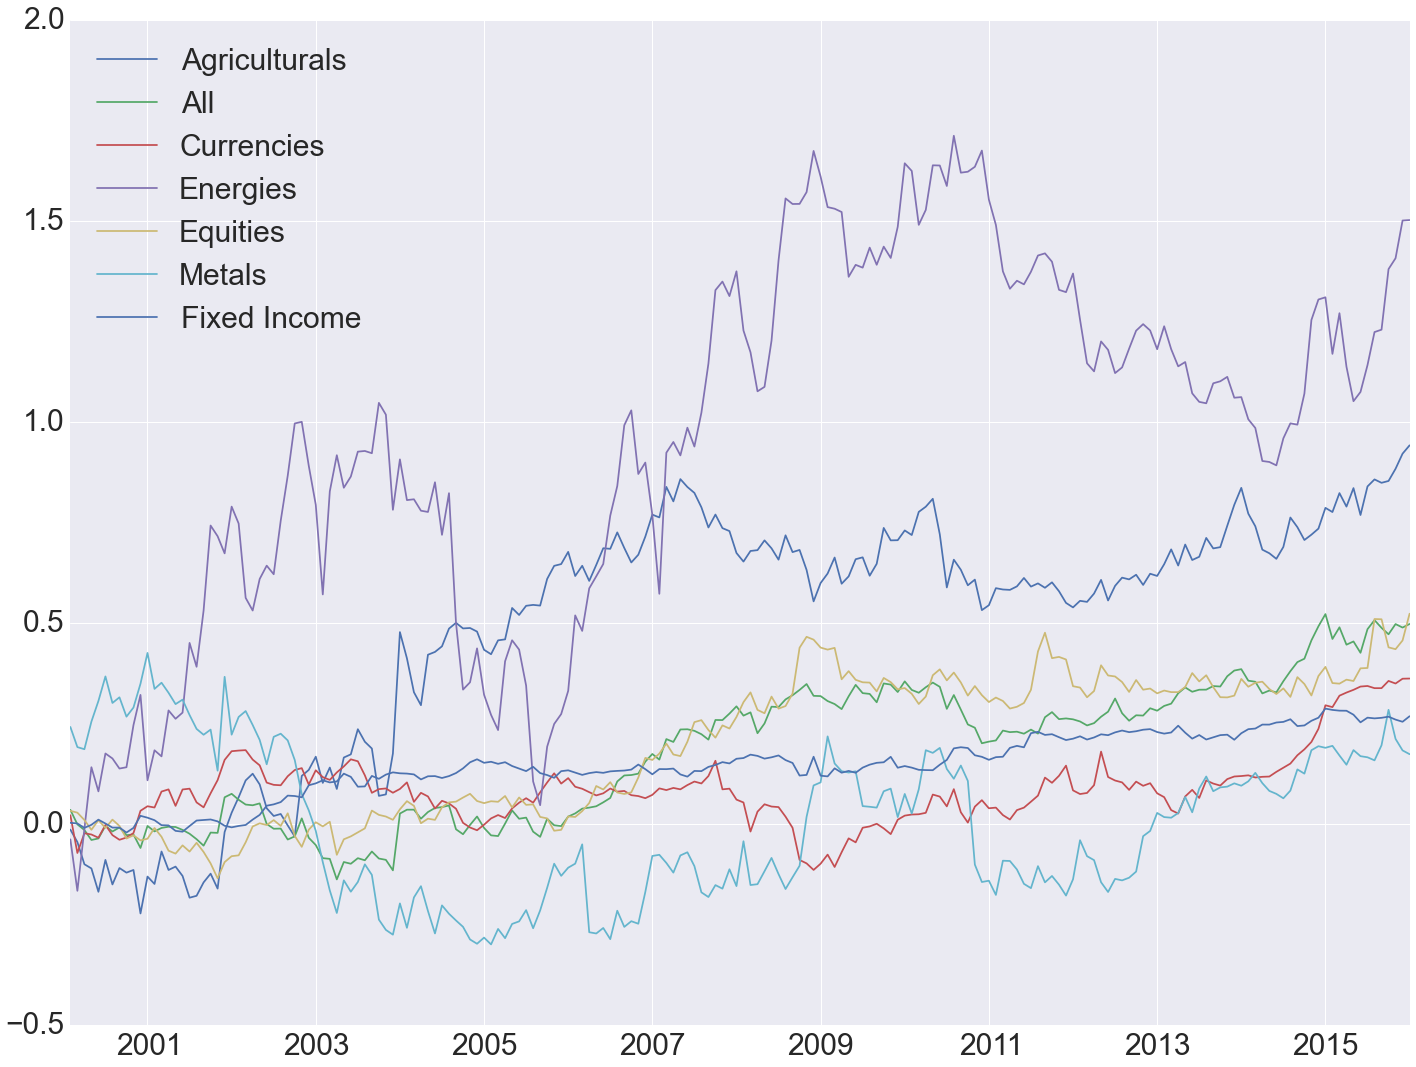

In [22]:
factors_monthly.cumsum().plot()

In [23]:
alpha={}
tstat={}
for sec in factors_monthly.columns:
    ind=factors_monthly['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    #reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')
    res=sm.OLS(factors_monthly[sec].loc[ind],reges.loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['AM']=res.params  *100
        betas_res['AM_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha A-M']=pd.Series(alpha)*100
final_res['tstat3']=pd.Series(tstat)

In [24]:
final_res

,alpha1,tstat,alpha F-A,tstat2,alpha A-M,tstat3
Agriculturals,0.292706,0.923185,0.234909,0.671411,0.595570,1.540660
All,0.505644,2.945640,0.618088,3.950819,0.459493,2.441452
Currencies,0.216395,1.387951,0.216793,1.146649,0.102577,0.590881
Energies,0.309175,0.375868,0.857008,1.298343,0.768939,1.012303
Equities,0.703638,3.461960,0.157116,0.693154,0.484839,2.364973
Fixed Income,0.043947,1.024600,-0.033734,-1.046072,0.034110,0.728847
Metals,-0.217278,-0.599442,-0.122875,-0.388558,0.037672,0.107537


# Monthly FHT

In [25]:
FHT_monthly = read_monthly(amihud=False,sorts=3,xs=True)

In [26]:
factors_monthly_FHT=pd.DataFrame()
for s in FHT_monthly.keys():
    factors_monthly_FHT[s]=FHT_monthly[s]['2']-FHT_monthly[s]['0']


In [27]:
alpha={}
tstat={}
for sec in factors_monthly_FHT.columns:
    ind=factors_monthly_FHT[sec]['2000':'2016'].dropna().index
#    ind=factors_monthly_FHT['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    #reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')
    res=sm.OLS(factors_monthly_FHT[sec].loc[ind],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['FM']=res.params  *100
        betas_res['FM_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha F-M']=pd.Series(alpha)*100
final_res['tstat4']=pd.Series(tstat)

In [28]:
betas_res

,AA,AA_T,FA,FA_T,AM,AM_T,FM,FM_T
VAL,-15.979658,-1.613606,-5.336516,-0.581277,-32.439840,-2.626498,-18.203338,-2.348651
MOM,-9.526317,-0.790653,-0.714671,-0.074560,-16.397364,-1.046914,-21.825852,-2.533759
TSMOM,5.214015,0.847518,-4.702176,-0.970073,4.069539,0.605001,4.305405,1.124270
CARRY,-23.142363,-2.667440,-16.556304,-2.183313,-13.246762,-1.329896,-3.174736,-0.501256
Market Return,-10.756048,-1.396696,129.981421,14.526516,-3.584279,-0.376606,38.015793,5.341409
const,0.505644,2.945640,0.618088,3.950819,0.459493,2.441452,0.119853,0.902105


# Alpha values 

$$r_{liquidity,t} = \alpha + \beta_1 r_{AssetClass,t} + \beta_2 MOM_{AssetClass,t} +
\beta_3 VAL_{AssetClass,t} + \varepsilon_t $$

In [29]:
final_res.T['All'].round(2)

alpha1       0.51
tstat        2.95
alpha F-A    0.62
tstat2       3.95
alpha A-M    0.46
tstat3       2.44
alpha F-M    0.12
tstat4       0.90
Name: All, dtype: float64

In [30]:
print(final_res.T[[u'Agriculturals', u'Currencies', u'Energies', u'Equities',
       u'Fixed Income', u'Metals', u'All']].round(2).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Agriculturals &  Currencies &  Energies &  Equities &  Fixed Income &  Metals &   All \\
\midrule
alpha1    &           0.29 &        0.22 &      0.31 &      0.70 &          0.04 &   -0.22 &  0.51 \\
tstat     &           0.92 &        1.39 &      0.38 &      3.46 &          1.02 &   -0.60 &  2.95 \\
alpha F-A &           0.23 &        0.22 &      0.86 &      0.16 &         -0.03 &   -0.12 &  0.62 \\
tstat2    &           0.67 &        1.15 &      1.30 &      0.69 &         -1.05 &   -0.39 &  3.95 \\
alpha A-M &           0.60 &        0.10 &      0.77 &      0.48 &          0.03 &    0.04 &  0.46 \\
tstat3    &           1.54 &        0.59 &      1.01 &      2.36 &          0.73 &    0.11 &  2.44 \\
alpha F-M &          -0.51 &       -0.20 &      1.51 &      0.31 &         -0.02 &   -0.19 &  0.12 \\
tstat4    &          -1.54 &       -1.21 &      2.08 &      1.37 &         -0.61 &   -0.61 &  0.90 \\
\bottomrule
\end{tabular}



# These results are so bad from the beta's to the factors point of view from all markets.  It's just way to high for FHT

I am not going to present them in the results.

In [43]:
print(betas_res.T.round(2)[['const','Market Return','VAL','MOM','TERM']].to_latex())

KeyError: "['TERM'] not in index"

# Adding additional factors

* TERM
* 

In [31]:
reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


In [34]:
betas_res

,AA,AA_T,FA,FA_T,AM,AM_T,FM,FM_T
VAL,4.894491,0.658063,-10.365014,-1.789100,1.830187,0.245592,-13.548865,-1.372981
MOM,-2.697738,-0.353982,-11.161096,-1.616071,-5.344737,-0.681562,-13.004126,-1.843249
Market Return,2.261443,0.421718,93.144699,11.578119,1.079371,0.204228,13.309223,2.644994
const,0.179068,1.467335,0.238169,2.331633,0.117758,0.914100,0.040309,0.301948
TERM,-0.044613,-0.237651,0.150633,1.047804,0.081865,0.416365,-0.084204,-0.421363


In [43]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:           Fixed Income   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     27.06
Date:                Fri, 17 Aug 2018   Prob (F-statistic):           6.18e-18
Time:                        16:28:13   Log-Likelihood:                 748.74
No. Observations:                 204   AIC:                            -1487.
Df Residuals:                     199   BIC:                            -1471.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
MOM_FI            0.0004      0.074      0.005

In [44]:
factors

,Agriculturals,All,Currencies,Energies,Equities,Metals,Fixed Income
2000-01-31,-0.055654,-0.010326,0.037552,-0.095232,0.012464,0.037483,-0.007752
2000-02-29,-0.003409,0.004095,0.031854,0.040961,0.029379,0.023852,-0.004405
2000-03-31,-0.008884,-0.007956,-0.001035,0.076088,-0.000987,-0.002141,-0.008619
2000-04-30,-0.003921,-0.006607,0.039218,0.126498,-0.034378,-0.009927,-0.003300
2000-05-31,-0.026950,-0.003539,0.001928,0.233571,-0.021745,0.019964,0.002273
2000-06-30,0.012682,0.002758,-0.049402,-0.119707,0.004284,0.048209,-0.000891
2000-07-31,-0.041162,-0.004238,0.048687,-0.031752,-0.028980,0.039559,-0.004844
2000-08-31,-0.045389,-0.024569,0.048859,0.008819,0.017555,-0.021808,-0.006436
2000-09-30,0.020757,0.008081,-0.011024,0.131204,0.011628,0.000492,0.000992
2000-10-31,-0.015319,-0.005942,0.037181,-0.001263,-0.042395,0.041517,-0.006692
